### Figure 02: Check how many wind events like ours happen in SVB using ERA5 winds
# Find wind events where winds blow towards the SE for 4 consecutive hours and wind stress is greater or equal to 0.1 Nm$^{-2}$. U and V wind components at 10 m from the dataset: ERA5 hourly data on single levels from 1979-present.

In [1]:
import cmocean as cmo
import datetime as dt
import matplotlib.gridspec as gridspec
from matplotlib.dates import date2num
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
import xarray as xr
from xmitgcm import open_mdsdataset

In [2]:
def stick_plot(time, u, v, **kw):
    '''Function by Filipe Fernandes: https://ocefpaf.github.io/python4oceanographers/blog/2014/09/15/stick_plot/'''
    width = kw.pop('width', 0.002)
    headwidth = kw.pop('headwidth', 0)
    headlength = kw.pop('headlength', 0)
    headaxislength = kw.pop('headaxislength', 0)
    angles = kw.pop('angles', 'uv')
    ax = kw.pop('ax', None)
    
    if angles != 'uv':
        raise AssertionError("Stickplot angles must be 'uv' so that"
                             "if *U*==*V* the angle of the arrow on"
                             "the plot is 45 degrees CCW from the *x*-axis.")

    time, u, v = map(np.asanyarray, (time, u, v))
    if not ax:
        fig, ax = plt.subplots()
    
    q = ax.quiver(date2num(time), [[0]*len(time)], u, v,
                  angles='uv', width=width,headwidth=headwidth, 
                  headlength=headlength, headaxislength=headaxislength, linewidth=0.001,
                  **kw)

    ax.axes.get_yaxis().set_visible(False)
    ax.xaxis_date()
    
    return q

def drag_coef_LP81(V10):
    '''Returns the drag coefficient Large and Pond (1981) style.
    V10 is the wind magnitude at 10 m.'''
    Cd = 0.001*(0.49+(0.065*V10))
    return(Cd)

def tau(U10, V10, rho=1.29):
    Umag = np.sqrt(U10**2+V10**2)
    taux,tauy = Umag*U10*drag_coef_LP81(Umag)*rho, Umag*V10*drag_coef_LP81(Umag)*rho
    return(taux,tauy)

### ERA5 file

I downloaded U and V components of wind at 4 pressure levels (1,10,100,500 hPa) for all of 2016 at a similar domain as the one I have in the model.

In [3]:
filename = '/home/sio-kramosmusalem/data/ERA5/2016_hourly_UV10m_4levs.nc'
dsw = xr.open_dataset(filename)

In [4]:
# Load coastline from model output
outdir = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL_SVB/01_SVB_febTS_output/'
iters = [20]
levels = [1]
ds = open_mdsdataset(outdir, prefix=['eta'], iters=iters, levels=levels)

In [5]:
depth = ds.Depth[:]
LAT = ds['YC'][:]
LON = ds['XC'][:]-360
lat = ds.YC[:,0].data
lon = ds.XC[0,:].data-360

# Points near Cedros Island and Guerrero Negro
xa1 = 22
xa2 = 23
ya1 = 25
ya2 = 26

xb1 = 26
xb2 = 27
yb1 = 27
yb2 = 28

In [6]:
# Hourly time series of U10 and V10 for 2016 
# Timeseries of mean U, V and speed at equivalent ICDN and GROM 
U_ICDN = (dsw.u10[:,ya1:ya2+1,xa1:xa2+1].mean(dim='latitude')).mean(dim='longitude')
V_ICDN = (dsw.v10[:,ya1:ya2+1,xa1:xa2+1].mean(dim='latitude')).mean(dim='longitude')
speed_ICDN = np.sqrt((dsw.u10[:,ya1:ya2+1,xa1:xa2+1]**2+dsw.v10[:,ya1:ya2+1,xa1:xa2+1]**2))
SPD_ICDN = (speed_ICDN.mean(dim='latitude')).mean(dim='longitude')

U_GROM = (dsw.u10[:,yb1:yb2+1,xb1:xb2+1].mean(dim='latitude')).mean(dim='longitude')
V_GROM = (dsw.v10[:,yb1:yb2+1,xb1:xb2+1].mean(dim='latitude')).mean(dim='longitude')
speed_GROM = np.sqrt((dsw.u10[:,yb1:yb2+1,xb1:xb2+1]**2+dsw.v10[:,yb1:yb2+1,xb1:xb2+1]**2))
SPD_GROM = (speed_GROM.mean(dim='latitude')).mean(dim='longitude')

In [7]:
# Time series of mean taux and tauy and speed at equivalent ICDN and GROM 
tx_GN, ty_GN = tau(U_GROM,V_GROM)
tx_IC, ty_IC = tau(U_ICDN,V_ICDN)

magTau_GN = np.sqrt((tx_GN**2+ty_GN**2))
magTau_IC = np.sqrt((tx_IC**2+ty_IC**2))

dirTau_GN = np.rad2deg(np.arctan2(ty_GN,tx_GN))
dirTau_IC = np.rad2deg(np.arctan2(ty_IC,tx_IC))

In [8]:
temp_IC = np.ma.masked_less(magTau_IC, 0.1)
taumask_IC = np.ma.getmask(temp_IC)

temp_GN = np.ma.masked_less(magTau_GN, 0.1)
taumask_GN = np.ma.getmask(temp_GN)

temp2_IC = np.ma.masked_greater(dirTau_IC, -25)
temp3_IC = np.ma.masked_less(temp2_IC, -90)

dirmask_IC = np.ma.getmask(temp3_IC)
tx_masked_IC = np.ma.masked_array(np.ma.masked_array(tx_IC, mask=taumask_IC), mask=dirmask_IC)
ty_masked_IC = np.ma.masked_array(np.ma.masked_array(ty_IC, mask=taumask_IC), mask=dirmask_IC)

temp2_GN = np.ma.masked_greater(dirTau_GN, -25)
temp3_GN = np.ma.masked_less(temp2_GN, -90)

dirmask_GN = np.ma.getmask(temp3_GN)
tx_masked_GN = np.ma.masked_array(np.ma.masked_array(tx_GN, mask=taumask_GN), mask=dirmask_GN)
ty_masked_GN = np.ma.masked_array(np.ma.masked_array(ty_GN, mask=taumask_GN), mask=dirmask_GN)

indices = []
for tt,T_hr in zip(range(len(dsw.time)), tx_masked_GN.mask):
    if T_hr == False:
        indices.append(tt)
        
indices2 = []
for tt,T_hr in zip(range(len(dsw.time)), tx_masked_IC.mask):
    if T_hr == False:
        indices2.append(tt)
        
events = []
ind_indices = []
for ii, ind in zip(range(len(indices)-1),indices[:-1]):
    if ind+1 == indices[ii+1]: 
        continue
    else:
        events.append(ind)
        ind_indices.append(ii)
        
events2 = []
ind_indices2 = []
for ii, ind in zip(range(len(indices2)-1),indices2[:-1]):
    if ind+1 == indices2[ii+1]: 
        continue
    else:
        events2.append(ind)
        ind_indices2.append(ii)

<ipython-input-9-3058270ee1ac>:43: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc = ax3.pcolormesh(dsw.longitude,dsw.latitude,  spd, cmap=cmo.cm.speed)
<ipython-input-9-3058270ee1ac>:47: UserWarning: No contour levels were found within the data range.
  ax3.contour(lon, lat, depth, levels=[-2,0], colors='w', linewidths=1)


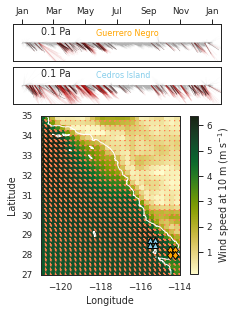

In [9]:
## === FIGURE ===
sns.set_style('white')
sns.set_context('paper')

fig = plt.figure(figsize=(7.48/2,9.2/2))
gs = gridspec.GridSpec(2,1, height_ratios=[0.5,1], hspace=0.1)
gs00 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0],hspace=0.15)

ax1 = fig.add_subplot(gs00[0])
ax2 = fig.add_subplot(gs00[1])
ax3 = fig.add_subplot(gs[1])

ax2.set_xticks([])
ax1.xaxis.set_ticks_position("top")

q1 = stick_plot(dsw.time, tx_GN, ty_GN, ax=ax1, width=0.0001, scale=2, color='0.7')
q2 = stick_plot(dsw.time, tx_masked_GN, ty_masked_GN, ax=ax1, width=0.0001, scale=2, color='red')
q5 = stick_plot(dsw.time[events], tx_masked_GN[events], ty_masked_GN[events],
                ax=ax1, width=0.00075, scale=2, color='k')
monthFmt = mdates.DateFormatter('%b')
ax1.xaxis.set_major_formatter(monthFmt)
q3 = stick_plot(dsw.time, tx_IC, ty_IC, ax=ax2, width=0.0001, scale=2, color='0.7')
q4 = stick_plot(dsw.time, tx_masked_IC, ty_masked_IC, ax=ax2, width=0.0001, scale=2, color='red')
q6 = stick_plot(dsw.time[events2], tx_masked_IC[events2], ty_masked_IC[events2],
                ax=ax2, width=0.00075, scale=2, color='k')

ax1.text(0.4,0.7,'Guerrero Negro', transform=ax1.transAxes, color='orange', fontsize=8)
ax2.text(0.4,0.7,'Cedros Island', transform=ax2.transAxes, color='skyblue',fontsize=8)

ref = 0.1
qk1 = ax1.quiverkey(q5, 0.1, 0.8, ref,
                    "%s Pa" % ref,
                    labelpos='E', coordinates='axes')

qk2 = ax2.quiverkey(q6, 0.1, 0.8, ref,
                    "%s Pa" % ref,
                    labelpos='E', coordinates='axes')

tind = 2000 
spd = np.sqrt(dsw.u10[:,...].mean(axis=0)**2 + dsw.v10[:,...].mean(axis=0)**2)

# Plot pcolor
pc = ax3.pcolormesh(dsw.longitude,dsw.latitude,  spd, cmap=cmo.cm.speed)
plt.colorbar(pc, ax=ax3, label=r'Wind speed at 10 m (m s$^{-1}$)')
ax3.quiver(dsw.longitude,dsw.latitude,dsw.u10.mean(axis=0),dsw.v10.mean(axis=0), 
          color='coral',linewidths=1,edgecolors='coral', pivot='middle')
ax3.contour(lon, lat, depth, levels=[-2,0], colors='w', linewidths=1)
lon_ICDN = [dsw.longitude[xa1], dsw.longitude[xa1], dsw.longitude[xa2], dsw.longitude[xa2]]
lat_ICDN = [dsw.latitude[ya1], dsw.latitude[ya2],dsw.latitude[ya1], dsw.latitude[ya2]]
lon_GROM = [dsw.longitude[xb1],dsw.longitude[xb1],dsw.longitude[xb2],dsw.longitude[xb2]]
lat_GROM = [dsw.latitude[yb1],dsw.latitude[yb2],dsw.latitude[yb1],dsw.latitude[yb2]]
ax3.plot(lon_ICDN, lat_ICDN, '^', color='skyblue', markeredgecolor='k', markersize=6)
ax3.plot(lon_GROM, lat_GROM, 'd', color='orange', markeredgecolor='k', markersize=6)

ax3.set_aspect(1)
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
ax3.set_title(str(dsw.time[tind].data))
ax3.set_xlim(-121,-114)
ax3.set_ylim(27,35)
ax3.set_title('')
plt.savefig('wind_events.png', dpi=500, bbox_inches='tight')

#### 